In [3]:
%pip install lxml
%pip install openpyxl
%pip install matplotlib
%pip install beautifulsoup4
%pip install pandas
%pip install requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Obtaining dependency information for charset-normalizer<4,>=2 from https://files.pythonhosted.org/packages/0f/16/8d50877a7215d31f024245a0acbda9e484dd70a21794f3109a6d8eaeba99/charset_normalizer-3.2.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.0 MB/s eta 0:00:00
  Obtaining dependency information for urllib3<3,>=1.21.1 from https://files.pythonhosted.org/packages/9b/81/62fd61001fa4b9d0df6e31d47ff49cfa9d

In [4]:
#vključimo podtrebne knjižnice za delovanje našega programa
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
import os

FILE_NAME = "laliga_all_seasons.xlsx"
ALL_DATA_SHEET = "All seasons Laliga data"

podatki =[]
def zamenjaj_naslove(imena_stolpcev):
    # spletna stran s katere smo prebrali podatke ima v glavi tabele krajšave npr. MP - match played.
    # krajšave bomo nadomestili v berljivejše podatke
    naslovi = {
        "MP": "Matches Played",
        "W": "Wins",
        "D": "Draws",
        "L": "Losses",
        "F": "Goals for",
        "A": "Goals against",
        "D": "Goal difference",
        "P": "Points",
        "#": "Position",
        
    }
    
    return [naslovi.get(stolpec, stolpec) for stolpec in imena_stolpcev]
def pridobivanje_podatkov_z_url(url):

    glava_zahtevka = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"
    }
    # zahtevek na url
    zahtevek = requests.get(url, headers=glava_zahtevka)
    if zahtevek.status_code == 200:
        # naložimo si vsebino s spletne strani
        soup = BeautifulSoup(zahtevek.content, 'lxml')
        # v vsebini spletne strani poiščemo tabelo z razredom 'leaguetable sortable table detailed-table',
        # ki vsebuje podatke o razporeditvi ekip na koncu izbrane sezone
        tabela = soup.find('table', class_='leaguetable sortable table detailed-table')
        
        # pridobimo glavo tabele
        glava_tabele = [header.text.strip() for header in tabela.thead.find_all('th')]
        # pridobimo vse vrstice s tabele
        vrstice = tabela.tbody.find_all('tr')
        podatki = []
        # beremo podatke s posamezne vrstice
        for vrstica in vrstice:
            stolpci = vrstica.find_all('td')
            podatki_stolpcev = [col.text.strip() for col in stolpci]
            podatki.append(podatki_stolpcev)
        
        return glava_tabele, podatki

    else:
        # v primeru da nam ni uspelo pridobiti podatkov s spletne strani, o tem obvestimo uporabnika
        print(f"Failed to retrieve the webpage. Status code: {zahtevek.status_code}")
        return None, None

def zapisi_v_datoteko():
    vrstice = []
    
    # razberemo naslove glave
    glava = ["Season"] + podatki[0]
    
    # pripnemo samo podatke
    for i in range(1, len(podatki), 3):
        sezona = podatki[i]
        podatki_za_sezono = podatki[i+1]

        for vrstica in podatki_za_sezono:
            vrstice.append([sezona] + vrstica)

    # poblikujemo strukturo podatkov
    df = pd.DataFrame(vrstice, columns=glava)

    # zapisemo v excel
    df.to_excel(FILE_NAME, index=False, sheet_name=ALL_DATA_SHEET)

    
def izvajanje_zahtevkov(od_leta, do_leta):
    
    URL_SPLETNE_STRANI = "https://int.soccerway.com/national/spain/primera-division/{od_sezone}{locilnik}{do_sezone}/{round}/"
    #predloga za url s koder bomo pridobivali podatke, za določene sezone se lahko struktura linka spremeni
    #primer linkov:
    # - 1993/94 : https://int.soccerway.com/national/spain/primera-division/1993-1994/round-1/r18/
    # - 2008/09 : https://int.soccerway.com/national/spain/primera-division/2008-2009/regular-season/r7081/
    # - 2016/17 : https://int.soccerway.com/national/spain/primera-division/20162017/v/r35880/
    # kot lahko vidimo se razlikujejo glede na izbrano sezono "1993-1994", "20162017" in po naslednji besedi po sezoni "round-1" "regular-season"
    glava =[]
    for leto in range(od_leta, do_leta + 1):
        sezona = f"{leto}-{leto+1}"
        # v for zanki sestavimo url za pridobivanje podatkov posamezne sezone
        if leto < 2012:
            if leto < 2003:
                url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,locilnik='-',round ='round-1')
            else:
                url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,locilnik='-', round ='regular-season')
        else:
            
            url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,round ='regular-season', locilnik = '')
            
        # metoda nam vrne glavo tabele in podatke s tabele, katere sproti shranjujemo v csv datoteko    
        glava, data = pridobivanje_podatkov_z_url(url)
        glava = zamenjaj_naslove(glava)
        if glava.__contains__(''):
            glava.remove('')
        for vrstica in data:
            if vrstica.__contains__(''):
                vrstica.remove('')
        if len(podatki) == 0:
            podatki.append(glava)
        if data:
            podatki.append(sezona)
            podatki.append(data)
            podatki.append('\n')
            
            print(f"Podatki za sezono {sezona} so bili shranjeni!")
        else:
            print(f"Neuspesno shranjevanje podatkov za sezono {sezona}")
    
# pridobivanje podatkov sezon od 1993 do 2023
izvajanje_zahtevkov(1993, 2023)
zapisi_v_datoteko()


Podatki za sezono 1993-1994 so bili shranjeni!
Podatki za sezono 1994-1995 so bili shranjeni!
Podatki za sezono 1995-1996 so bili shranjeni!
Podatki za sezono 1996-1997 so bili shranjeni!
Podatki za sezono 1997-1998 so bili shranjeni!
Podatki za sezono 1998-1999 so bili shranjeni!
Podatki za sezono 1999-2000 so bili shranjeni!
Podatki za sezono 2000-2001 so bili shranjeni!
Podatki za sezono 2001-2002 so bili shranjeni!
Podatki za sezono 2002-2003 so bili shranjeni!
Podatki za sezono 2003-2004 so bili shranjeni!
Podatki za sezono 2004-2005 so bili shranjeni!
Podatki za sezono 2005-2006 so bili shranjeni!
Podatki za sezono 2006-2007 so bili shranjeni!
Podatki za sezono 2007-2008 so bili shranjeni!
Podatki za sezono 2008-2009 so bili shranjeni!
Podatki za sezono 2009-2010 so bili shranjeni!
Podatki za sezono 2010-2011 so bili shranjeni!
Podatki za sezono 2011-2012 so bili shranjeni!
Podatki za sezono 2012-2013 so bili shranjeni!
Podatki za sezono 2013-2014 so bili shranjeni!
Podatki za se

# Preberemo podatke

In [5]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load the data from the Excel file
laliga_podatki = pd.read_excel(FILE_NAME)

# Display the first few rows of the dataset
laliga_podatki.head(20)

,Season,Position,Team,Matches Played,Wins,Goal difference,Losses,Goals for,Goals against,Goal difference.1,Points,Last 5 matches,H2H
0,1993-1994,1,Barcelona,38,25,6,7,91,42,49,56,W\nW\nW\nW\nW,NaN
1,1993-1994,2,Deportivo La C…,38,22,12,4,54,18,36,56,D\nW\nD\nD\nW,NaN
2,1993-1994,3,Real Zaragoza,38,19,8,11,71,47,24,46,W\nW\nW\nL\nD,NaN
3,1993-1994,4,Real Madrid,38,19,7,12,61,49,12,45,L\nL\nW\nL\nW,NaN
4,1993-1994,5,Athletic Bilbao,38,16,11,11,61,47,14,43,W\nD\nD\nD\nL,NaN
5,1993-1994,6,Sevilla,38,15,12,11,56,42,14,42,L\nW\nD\nD\nL,NaN
6,1993-1994,7,Valencia,38,14,12,12,55,50,5,40,D\nW\nD\nW\nL,NaN
7,1993-1994,8,Racing Santander,38,15,8,15,44,42,2,38,W\nL\nD\nW\nL,NaN
8,1993-1994,9,Real Oviedo,38,12,13,13,43,49,-6,37,L\nD\nD\nD\nW,NaN
9,1993-1994,10,Tenerife,38,15,6,17,50,57,-7,36,L\nW\nL\nD\nL,NaN


### Pomozna funkcija za dodajanje podatkov 

Podatke katere bomo pridobili z analizo podatkov, bomo s pomočjo spodnje funkcije shranili v nov list

In [6]:
def new_sheet(sheet,data):
    with pd.ExcelWriter(FILE_NAME, mode='a', engine='openpyxl') as writer:
        data.to_excel(writer, index=True, sheet_name=sheet)

### Različne ekipe
Izpis vseh razlicnih ekip


In [7]:
 
ekipe = pd.Series(laliga_podatki['Team'].unique()).sort_values()
new_sheet('Razlicne ekipe', ekipe)
ekipe



28               Alaves
12             Albacete
39              Almeria
4       Athletic Bilbao
11      Atletico Madrid
0             Barcelona
15          CD Logroñés
25       CF Extremadura
37                Cadiz
14           Celta Vigo
22           Compostela
44              Córdoba
1       Deportivo La C…
43                Eibar
42                Elche
21             Espanyol
35               Getafe
38      Gimnàstic Tarr…
46               Girona
41              Granada
47               Huesca
26             Hércules
32           Las Palmas
45              Leganes
18               Lerida
36              Levante
30               Malaga
27             Mallorca
23            Mérida UD
31             Numancia
19              Osasuna
7      Racing Santander
16       Rayo Vallecano
20           Real Betis
3           Real Madrid
34          Real Murcia
8           Real Oviedo
10        Real Sociedad
17      Real Valladolid
2         Real Zaragoza
33    Recreativo Huelva
5               

### Vsota zmag
Izpis stevilo naslovov za posamezno ekipo

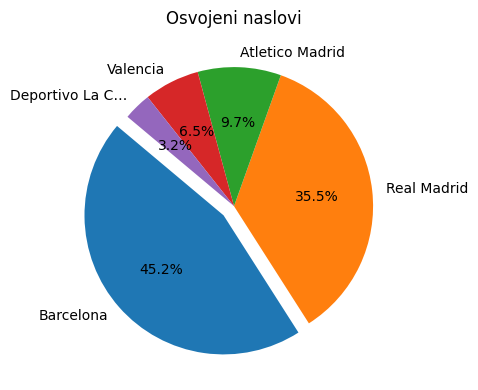

Team
Barcelona          14
Real Madrid        11
Atletico Madrid     3
Valencia            2
Deportivo La C…     1
Name: count, dtype: int64

In [8]:
zmagovalci = laliga_podatki[laliga_podatki['Position'] == 1]
naslovi = zmagovalci['Team'].value_counts()
new_sheet('Sestevek naslovov', naslovi)
# Plotting a pie chart
plt.figure(figsize=(5, 4))
naslovi.plot.pie(autopct='%1.1f%%', startangle=140, explode=[0.1] + [0]*(len(naslovi)-1))
plt.title('Osvojeni naslovi')
plt.ylabel('')  # Removing the default 'Team' ylabel for better aesthetics
plt.tight_layout()
plt.show()
naslovi

### Seštevek

Za vsako ekipo smo vzeli podatke iz vseh sezon in jih sešteli.
Nato smo vse skupaj razvrstili glede na pridobljene točke in ugotovili,
da je največ točk v sezonah med letom 1993 in 2023 pridobila Barcelona.  

In [9]:
ekipe = laliga_podatki.drop(columns=[col for col in laliga_podatki.columns if 'Unnamed' in col or col == 'H2H'])
ekipe = ekipe.drop(columns=['Season', 'Position', 'Last 5 matches'])
ekipe_vsota_podatkov = ekipe.groupby('Team').sum().sort_values(by='Points', ascending=False).head(15)
new_sheet('Vsota podatkov', ekipe_vsota_podatkov)
ekipe_vsota_podatkov


,Matches Played,Wins,Goal difference,Losses,Goals for,Goals against,Goal difference.1,Points
Team,,,,,,,,
Barcelona,1150,736,229,185,2602,1107,1495,2394
Real Madrid,1150,727,219,204,2497,1204,1293,2358
Atletico Madrid,1074,522,261,291,1704,1168,536,1801
Valencia,1150,508,295,347,1723,1349,374,1792
Athletic Bilbao,1150,425,324,401,1494,1498,-4,1567
Sevilla,1036,447,252,337,1497,1269,228,1562
Real Sociedad,1036,390,279,367,1396,1347,49,1425
Espanyol,1072,351,298,423,1267,1427,-160,1337
Villarreal,876,363,230,283,1245,1063,182,1319


### Povprecje zmag in tock

Povprecje zmag in tock skozi vse sezone

In [10]:
ekipe_povprecje = laliga_podatki.groupby('Team').mean()
ekipe_povprecje.reset_index(inplace=True)
team_avg_selected = ekipe_povprecje[['Team', 'Wins', 'Points']].sort_values(by='Points', ascending=False)
new_sheet('Povprecje zmag in tock',team_avg_selected)
team_avg_selected 
#neki morm popraut

TypeError: Could not convert 1998-19991999-20002000-20012001-20022002-20032005-20062016-20172017-20182018-20192019-20202020-20212021-20222023-2024 to numeric

### Zbrane tocke najboljsih 5 ekip med sezonami 1993/94 in 2023/24 

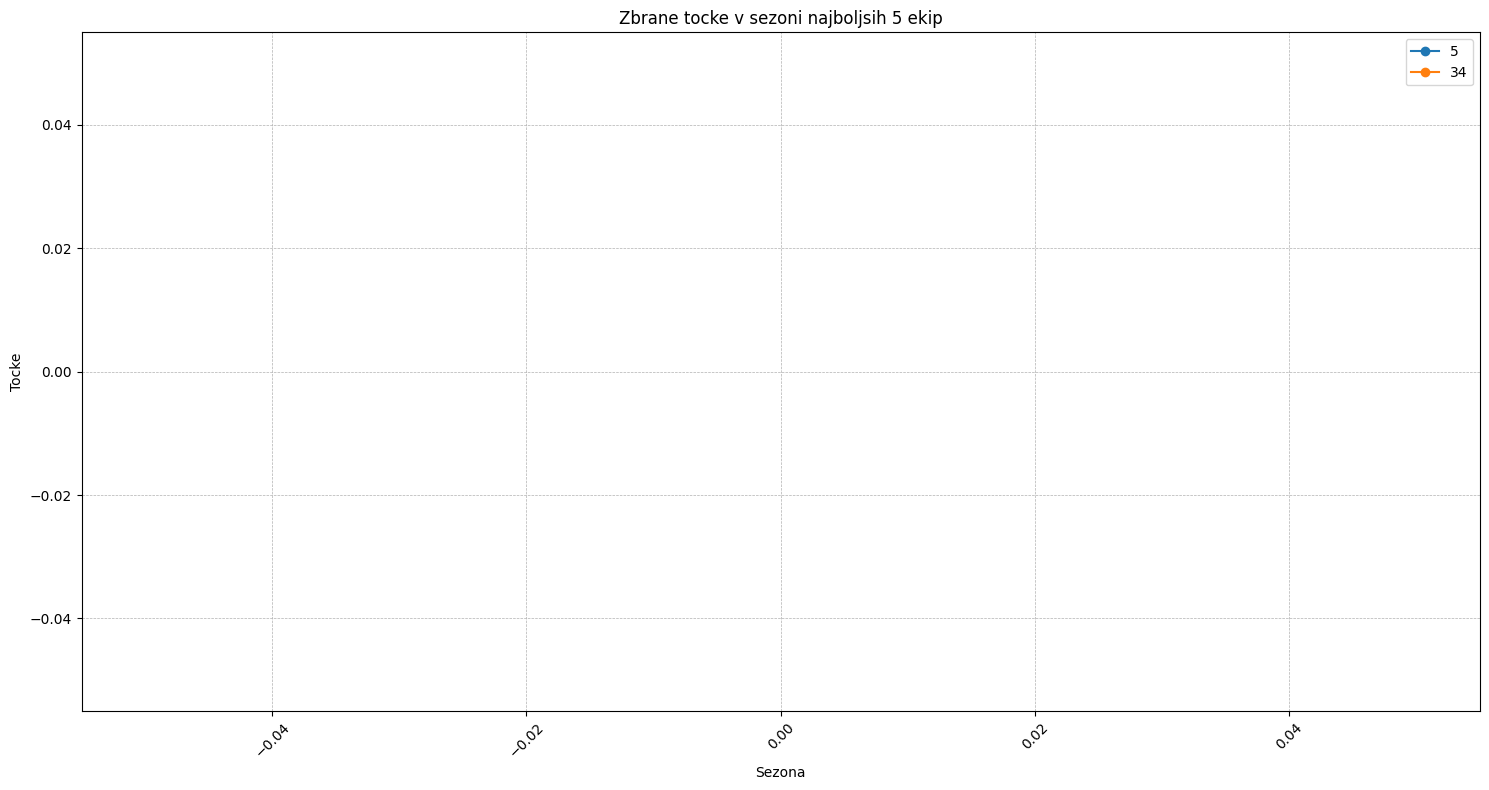

In [19]:


top_5 = team_avg_selected.sort_values(by='Points', ascending=False).head(2).index
top_5_podatki = laliga_podatki[laliga_podatki['Team'].isin(top_5)]

plt.figure(figsize=(15, 8))

for team in top_5:
    ekipa = top_5_podatki[top_5_podatki['Team'] == team]
    plt.plot(ekipa['Season'], ekipa['Points'], label=team, marker='o')

plt.title('Zbrane tocke v sezoni najboljsih 5 ekip')
plt.xlabel('Sezona')
plt.ylabel('Tocke')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
